In [1]:
from __future__ import absolute_import, division, print_function


from tf_agents.environments import suite_gym
from tf_agents.environments.wrappers import ActionRepeat
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.networks.q_network import QNetwork
from tf_agents.agents.dqn.dqn_agent import DqnAgent
import tensorflow as tf
import tensorflow.keras as keras
from gym.wrappers import TimeLimit
import matplotlib.pyplot as plt


import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [2]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [3]:
num_iterations = 1000000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 80000  # @param {type:"integer"}

batch_size = 32  # @param {type:"integer"}
learning_rate = 2.5e-4  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

/home/hunter/anaconda3/envs/RL/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'tf_agents.environments.atari_preprocessing.AtariPreprocessing'> doesn't implement 'reset' method, which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


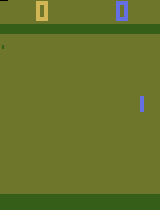

In [4]:
env_name = "PongNoFrameskip-v4"
env = suite_gym.load(env_name,max_episode_steps = 800,gym_env_wrappers=[AtariPreprocessing, FrameStack4])
env.reset()
PIL.Image.fromarray(env.render())

In [5]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [19]:
preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255)
conv_layer_params = [(32,8,4),(64,4,2),(64,3,1)]
fc_layer_params = (512,)

q_net = QNetwork(train_env.observation_spec(),
                train_env.action_spec(),
                preprocessing_layers=preprocessing_layer,
                conv_layer_params=conv_layer_params,
                fc_layer_params=fc_layer_params)

In [20]:
train_step = tf.Variable(0)
update_period = 4
optimizer = keras.optimizers.RMSprop(lr=2.5e-4,rho=0.95,momentum=0.0,
                                    epsilon=0.00001,centered=True)

epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
                initial_learning_rate=1.0,
                decay_steps = 250000 // update_period,
                end_learning_rate=0.01)

agent = DqnAgent(train_env.time_step_spec(),
                train_env.action_spec(),
                q_network=q_net,
                optimizer=optimizer,
                target_update_period=2000,
                td_errors_loss_fn = keras.losses.Huber(reduction='none'),
                gamma=0.99,
                train_step_counter=train_step,
                epsilon_greedy=lambda: epsilon_fn(train_step))

agent.initialize()

In [21]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [22]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [23]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [24]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)


-20.0

In [25]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [26]:
agent.collect_data_spec


Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(210, 160, 3), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(5)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [27]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [28]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=800)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://github.com/tensorflow/agents/blob/master/tf_agents/docs/python/tf_agents/drivers.md


In [29]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(step_type=(32, 2), observation=(32, 2, 210, 160, 3), action=(32, 2), policy_info=(), next_step_type=(32, 2), reward=(32, 2), discount=(32, 2)), BufferInfo(ids=(32, 2), probabilities=(32,))), types: (Trajectory(step_type=tf.int32, observation=tf.uint8, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [30]:
iterator = iter(dataset)

print(iterator)

In [34]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 7.507310510845855e-05
step = 400: loss = 0.0005617969436571002
step = 600: loss = 0.0004819167370442301
step = 800: loss = 0.00043140698107890785
step = 1000: loss = 0.006932405289262533
step = 1000: Average Return = -19.0
step = 1200: loss = 0.0016136913327500224
step = 1400: loss = 0.0016825480852276087
step = 1600: loss = 0.00026422744849696755
step = 1800: loss = 0.0008955611847341061
step = 2000: loss = 0.00040434260154142976
step = 2000: Average Return = -20.0
step = 2200: loss = 0.0002815502230077982
step = 2400: loss = 0.00024033701629377902
step = 2600: loss = 0.00011516117956489325
step = 2800: loss = 0.003458414226770401
step = 3000: loss = 0.0002733294968493283
step = 3000: Average Return = -20.0
step = 3200: loss = 0.0002873480843845755
step = 3400: loss = 0.0002381534141022712
step = 3600: loss = 0.0007744015892967582
step = 3800: loss = 0.00029034592444077134
step = 4000: loss = 0.00029683700995519757
step = 4000: Average Return = -21.0
step = 4200: lo

step = 33000: loss = 0.0003219411591999233
step = 33000: Average Return = -21.0
step = 33200: loss = 0.00039836709038354456
step = 33400: loss = 0.0003528422676026821
step = 33600: loss = 0.01672813668847084
step = 33800: loss = 0.0001800462487153709
step = 34000: loss = 0.0001529402652522549
step = 34000: Average Return = -21.0
step = 34200: loss = 0.0014992649666965008
step = 34400: loss = 0.00018859829287976027
step = 34600: loss = 0.0004210616461932659
step = 34800: loss = 0.004745563492178917
step = 35000: loss = 0.0002268816315336153
step = 35000: Average Return = -21.0
step = 35200: loss = 0.0002186416822951287
step = 35400: loss = 0.0006405994645319879
step = 35600: loss = 0.0002664053754415363
step = 35800: loss = 0.0003198066260665655
step = 36000: loss = 0.00013451880658976734
step = 36000: Average Return = -20.0
step = 36200: loss = 0.0021787399891763926
step = 36400: loss = 0.00055528967641294
step = 36600: loss = 0.0001886667450889945
step = 36800: loss = 0.00123472197446

step = 65400: loss = 0.0014716548612341285
step = 65600: loss = 0.0005944047588855028
step = 65800: loss = 0.0001477760379202664
step = 66000: loss = 0.0009036294068209827
step = 66000: Average Return = -21.0
step = 66200: loss = 0.002658517099916935
step = 66400: loss = 0.0008589349454268813
step = 66600: loss = 0.0006065106717869639
step = 66800: loss = 0.00041667724144645035
step = 67000: loss = 0.0004318807041272521
step = 67000: Average Return = -21.0
step = 67200: loss = 0.0007268721819855273
step = 67400: loss = 0.0010181446559727192
step = 67600: loss = 0.010229600593447685
step = 67800: loss = 0.001226135529577732
step = 68000: loss = 0.0019766134209930897
step = 68000: Average Return = -21.0
step = 68200: loss = 0.0004130150191485882
step = 68400: loss = 0.0007680294220335782
step = 68600: loss = 0.0008318402688018978
step = 68800: loss = 0.001394795486703515
step = 69000: loss = 0.0005568044725805521
step = 69000: Average Return = -21.0
step = 69200: loss = 0.000510088517330

step = 98000: Average Return = -21.0
step = 98200: loss = 0.0005111374193802476
step = 98400: loss = 0.0004308904171921313
step = 98600: loss = 0.0010750994551926851
step = 98800: loss = 0.0008081676787696779
step = 99000: loss = 0.0071191731840372086
step = 99000: Average Return = -20.0
step = 99200: loss = 0.0005358402268029749
step = 99400: loss = 0.007461681496351957
step = 99600: loss = 0.001659637549892068
step = 99800: loss = 0.0005903308046981692
step = 100000: loss = 0.0014789168490096927
step = 100000: Average Return = -21.0
step = 100200: loss = 0.00027594337007030845
step = 100400: loss = 0.00033697750768624246
step = 100600: loss = 0.0006166759412735701
step = 100800: loss = 0.0005349168786779046
step = 101000: loss = 0.0014395052567124367
step = 101000: Average Return = -20.0
step = 101200: loss = 0.0016722212312743068
step = 101400: loss = 0.0010686831083148718
step = 101600: loss = 0.000656136660836637
step = 101800: loss = 0.0004090660368092358
step = 102000: loss = 0.

step = 130000: Average Return = -20.0
step = 130200: loss = 0.0023657940328121185
step = 130400: loss = 0.001782188774086535
step = 130600: loss = 0.0009934311965480447
step = 130800: loss = 0.00046715419739484787
step = 131000: loss = 0.0005348033737391233
step = 131000: Average Return = -21.0
step = 131200: loss = 0.0005813054158352315
step = 131400: loss = 0.0004080795624759048
step = 131600: loss = 0.01234182994812727
step = 131800: loss = 0.0004223202995490283
step = 132000: loss = 0.0005137153202667832
step = 132000: Average Return = -20.0
step = 132200: loss = 0.0010872399434447289
step = 132400: loss = 0.00043438031570985913
step = 132600: loss = 0.0003871700610034168
step = 132800: loss = 0.0012140879407525063
step = 133000: loss = 0.0005876111681573093
step = 133000: Average Return = -21.0
step = 133200: loss = 0.0011337811592966318
step = 133400: loss = 0.00044791019172407687
step = 133600: loss = 0.0013732436345890164
step = 133800: loss = 0.0027463617734611034
step = 13400

step = 162000: Average Return = -21.0
step = 162200: loss = 0.0008508127648383379
step = 162400: loss = 0.01819118857383728
step = 162600: loss = 0.014898724853992462
step = 162800: loss = 0.0016082744114100933
step = 163000: loss = 0.0005003240657970309
step = 163000: Average Return = -21.0
step = 163200: loss = 0.0010342071764171124
step = 163400: loss = 0.01910114474594593
step = 163600: loss = 0.0010007091332226992
step = 163800: loss = 0.0007561828242614865
step = 164000: loss = 0.007778056897222996
step = 164000: Average Return = -20.0
step = 164200: loss = 0.001019094604998827
step = 164400: loss = 0.008887727744877338
step = 164600: loss = 0.00041938567301258445
step = 164800: loss = 0.0007538265199400485
step = 165000: loss = 0.001199305523186922
step = 165000: Average Return = -20.0
step = 165200: loss = 0.001211873721331358
step = 165400: loss = 0.000636301701888442
step = 165600: loss = 0.0004017550963908434
step = 165800: loss = 0.0018027538899332285
step = 166000: loss = 

step = 194000: Average Return = -21.0
step = 194200: loss = 0.0026673292741179466
step = 194400: loss = 0.0006898726569488645
step = 194600: loss = 0.001598409260623157
step = 194800: loss = 0.0002579345309641212
step = 195000: loss = 0.007028692867606878
step = 195000: Average Return = -21.0
step = 195200: loss = 0.001135858241468668
step = 195400: loss = 0.002130062086507678
step = 195600: loss = 0.0008886315627023578
step = 195800: loss = 0.0007873630383983254
step = 196000: loss = 0.0004377133445814252
step = 196000: Average Return = -21.0
step = 196200: loss = 0.0003313653578516096
step = 196400: loss = 0.0029368342366069555
step = 196600: loss = 0.0003199053753633052
step = 196800: loss = 0.0004893522709608078
step = 197000: loss = 0.00070315005723387
step = 197000: Average Return = -21.0
step = 197200: loss = 0.003513248870149255
step = 197400: loss = 0.0011069028405472636
step = 197600: loss = 0.0007173326448537409
step = 197800: loss = 0.0009881636360660195
step = 198000: loss

step = 226000: Average Return = -20.0
step = 226200: loss = 0.00023639613937120885
step = 226400: loss = 0.0038102674297988415
step = 226600: loss = 0.003603864461183548
step = 226800: loss = 0.009735033847391605
step = 227000: loss = 0.0007818237645551562
step = 227000: Average Return = -21.0
step = 227200: loss = 0.0013819357845932245
step = 227400: loss = 0.0011040463577955961
step = 227600: loss = 0.0007436675950884819
step = 227800: loss = 0.0011405372060835361
step = 228000: loss = 0.0028640739619731903
step = 228000: Average Return = -20.0
step = 228200: loss = 0.0003617395996116102
step = 228400: loss = 0.0017869769362732768
step = 228600: loss = 0.0011889832094311714
step = 228800: loss = 0.005969197954982519
step = 229000: loss = 0.0011662275064736605
step = 229000: Average Return = -21.0
step = 229200: loss = 0.0004707594634965062
step = 229400: loss = 0.0016497515607625246
step = 229600: loss = 0.0005916774389334023
step = 229800: loss = 0.0010848059318959713
step = 230000:

step = 258000: Average Return = -20.0
step = 258200: loss = 0.0011486544972285628
step = 258400: loss = 0.014058304950594902
step = 258600: loss = 0.012851867824792862
step = 258800: loss = 0.0010011850390583277
step = 259000: loss = 0.020419809967279434
step = 259000: Average Return = -21.0
step = 259200: loss = 0.0010211452608928084
step = 259400: loss = 0.0006579284672625363
step = 259600: loss = 0.0008935339283198118
step = 259800: loss = 0.0012441595317795873
step = 260000: loss = 0.0033949839416891336


KeyboardInterrupt: 

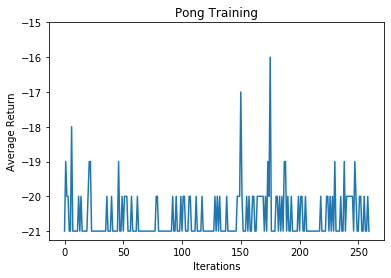

In [37]:
## iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.title('Pong Training')
plt.ylim(top=-15)
plt.savefig('Pong_Training_Reward_Plot.png')

In [38]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [39]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")

KeyboardInterrupt: 